# Bank Analytics System - Exploratory Data Analysis

## Executive Summary

This notebook provides comprehensive exploratory data analysis of the bank analytics database containing approximately 1 million transactions. The analysis focuses on:

- **Customer Segmentation**: Understanding customer behavior, credit profiles, and value tiers
- **Transaction Patterns**: Identifying trends, seasonality, and high-value activity
- **Risk Assessment**: Detecting potential fraud, high-risk customers, and portfolio exposure
- **Revenue Optimization**: Analyzing merchant performance, account balances, and cross-sell opportunities
- **Portfolio Health**: Examining loan distribution, interest rates, and credit risk

### Business Context

The banking industry operates in a highly competitive environment where data-driven insights are critical for:
- Customer retention and lifetime value optimization
- Risk management and fraud prevention
- Product development and cross-selling strategies
- Regulatory compliance and reporting

### Analytical Approach

We leverage SQL for efficient data extraction and aggregation, then use Python (pandas, numpy) for advanced analytics and visualization (plotly, seaborn, matplotlib) to derive actionable business insights.

---

**Author**: Principal Data Analyst  
**Date**: February 5, 2026  
**Database**: Bank Analytics System  
**Dataset Size**: ~1M transactions

## 1. Environment Setup and Database Connection

In [ ]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sqlalchemy import create_engine
import warnings
from datetime import datetime, timedelta

# Configure display settings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.2f}'.format)

# Set visualization styles
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print("Libraries imported successfully")
print(f"Analysis Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

Libraries imported successfully
Analysis Date: 2026-02-05 12:18:44


In [ ]:
# Database connection configuration
# NOTE: Update these credentials with your actual database connection details

DB_HOST = '*******'
DB_PORT = '*******'
DB_NAME = '*******'
DB_USER = '*******'
DB_PASSWORD = '*******'

# Create database connection string
connection_string = f'mysql+pymysql://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}'

# Establish connection
engine = create_engine(connection_string, pool_pre_ping=True)

print("Database connection established successfully")
print(f"Connected to: {DB_NAME} at {DB_HOST}")

Database connection established successfully
Connected to: bank at localhost


## 2. Data Extraction and Initial Profiling

In [ ]:
# Extract table row counts for data profiling
query_row_counts = """
SELECT 'customers' AS table_name, COUNT(*) AS row_count FROM customers
UNION ALL SELECT 'accounts', COUNT(*) FROM accounts
UNION ALL SELECT 'cards', COUNT(*) FROM cards
UNION ALL SELECT 'merchants', COUNT(*) FROM merchants
UNION ALL SELECT 'branches', COUNT(*) FROM branches
UNION ALL SELECT 'loans', COUNT(*) FROM loans
UNION ALL SELECT 'transactions', COUNT(*) FROM transactions;
"""

df_row_counts = pd.read_sql(query_row_counts, engine)
print("\n=== DATABASE TABLE SUMMARY ===")
print(df_row_counts.to_string(index=False))
print(f"\nTotal Records Across All Tables: {df_row_counts['row_count'].sum():,}")


=== DATABASE TABLE SUMMARY ===
  table_name  row_count
   customers      50000
    accounts      75000
       cards     100000
   merchants       5000
    branches        500
       loans      30000
transactions    1000000

Total Records Across All Tables: 1,260,500


In [ ]:
# Data quality assessment
query_data_quality = """
SELECT
    COUNT(*) AS total_customers,
    SUM(CASE WHEN email IS NULL THEN 1 ELSE 0 END) AS missing_email,
    SUM(CASE WHEN city IS NULL THEN 1 ELSE 0 END) AS missing_city,
    SUM(CASE WHEN credit_score IS NULL THEN 1 ELSE 0 END) AS missing_credit_score,
    ROUND(100.0 * SUM(CASE WHEN credit_score IS NULL THEN 1 ELSE 0 END) / COUNT(*), 2) AS pct_missing_credit
FROM customers;
"""

df_data_quality = pd.read_sql(query_data_quality, engine)
print("\n=== DATA QUALITY SUMMARY ===")
print(df_data_quality.to_string(index=False))


=== DATA QUALITY SUMMARY ===
 total_customers  missing_email  missing_city  missing_credit_score  pct_missing_credit
           50000           0.00          0.00                  0.00                0.00


In [ ]:
# Extract comprehensive business KPIs
query_kpis = """
SELECT 'Total Customers' AS metric, COUNT(DISTINCT customer_id) AS value FROM customers
UNION ALL SELECT 'Total Accounts', COUNT(*) FROM accounts
UNION ALL SELECT 'Total Balance (USD)', ROUND(SUM(balance_usd), 2) FROM accounts
UNION ALL SELECT 'Total Transactions', COUNT(*) FROM transactions
UNION ALL SELECT 'Total Transaction Volume (USD)', ROUND(SUM(amount_usd), 2) FROM transactions
UNION ALL SELECT 'Total Loans', COUNT(*) FROM loans
UNION ALL SELECT 'Total Loan Exposure (USD)', ROUND(SUM(loan_amount), 2) FROM loans
UNION ALL SELECT 'Average Credit Score', ROUND(AVG(credit_score), 0) FROM customers WHERE credit_score IS NOT NULL;
"""

df_kpis = pd.read_sql(query_kpis, engine)
print("\n=== KEY BUSINESS METRICS ===")
print(df_kpis.to_string(index=False))


=== KEY BUSINESS METRICS ===
                        metric         value
               Total Customers      50000.00
                Total Accounts      75000.00
           Total Balance (USD) 7494138742.77
            Total Transactions    1000000.00
Total Transaction Volume (USD) 5001164534.00
                   Total Loans      30000.00
     Total Loan Exposure (USD) 4513099925.48
          Average Credit Score        575.00


## 3. Customer Analytics

In [ ]:
# Customer credit score segmentation
query_credit_segments = """
SELECT
    CASE
        WHEN credit_score >= 750 THEN 'Excellent (750+)'
        WHEN credit_score >= 700 THEN 'Good (700-749)'
        WHEN credit_score >= 650 THEN 'Fair (650-699)'
        WHEN credit_score >= 600 THEN 'Poor (600-649)'
        ELSE 'Very Poor (<600)'
    END AS credit_segment,
    COUNT(*) AS customer_count,
    ROUND(100.0 * COUNT(*) / SUM(COUNT(*)) OVER(), 2) AS pct_of_total,
    ROUND(AVG(credit_score), 0) AS avg_credit_score
FROM customers
WHERE credit_score IS NOT NULL
GROUP BY credit_segment
ORDER BY MIN(credit_score) DESC;
"""

df_credit_segments = pd.read_sql(query_credit_segments, engine)
print("\n=== CUSTOMER CREDIT SCORE DISTRIBUTION ===")
print(df_credit_segments.to_string(index=False))


=== CUSTOMER CREDIT SCORE DISTRIBUTION ===
  credit_segment  customer_count  pct_of_total  avg_credit_score
Excellent (750+)            9143         18.29            800.00
  Good (700-749)            4599          9.20            724.00
  Fair (650-699)            4571          9.14            675.00
  Poor (600-649)            4565          9.13            625.00
Very Poor (<600)           27122         54.24            449.00


In [ ]:
# Visualize credit score distribution
fig = px.pie(df_credit_segments,
             values='customer_count',
             names='credit_segment',
             title='Customer Distribution by Credit Score Segment',
             color_discrete_sequence=px.colors.sequential.RdBu,
             hole=0.3)

fig.update_traces(textposition='inside', textinfo='percent+label')
fig.update_layout(height=500, showlegend=True)
fig.show()

In [ ]:
# Top customers by total balance
query_top_customers = """
SELECT
    c.customer_id,
    CONCAT(c.first_name, ' ', c.last_name) AS customer_name,
    c.city,
    c.credit_score,
    COUNT(DISTINCT a.account_id) AS num_accounts,
    SUM(a.balance_usd) AS total_balance
FROM customers c
INNER JOIN accounts a ON c.customer_id = a.customer_id
GROUP BY c.customer_id, c.first_name, c.last_name, c.city, c.credit_score
ORDER BY total_balance DESC
LIMIT 50;
"""

df_top_customers = pd.read_sql(query_top_customers, engine)
print("\n=== TOP 20 CUSTOMERS BY BALANCE ===")
print(df_top_customers.head(20).to_string(index=False))


=== TOP 20 CUSTOMERS BY BALANCE ===
    customer_id       customer_name               city  credit_score  num_accounts  total_balance
CUSR0YLDNY6JTT9     Thomas Cardenas        Maynardbury           630             7     1040545.37
CUSFGCY49WIMIV2       Karen Murillo      Michellemouth           565             7     1003731.76
CUSSM6FW1WQKK6K   Matthew Patterson        Turnerburgh           718             8      990702.58
CUS5GFGV4X2ENHJ Benjamin Montgomery         Perryshire           574             7      941046.13
CUSLOCVS96YCXNE       Bradley Gomez        North Kelly           327             7      930405.09
CUSE0IPCT6C0BR3      Rachel Johnson      Lake Kimberly           607             7      927765.14
CUSFU77E0CQ5MTI     Michael Johnson        Nicolehaven           327             7      923396.03
CUSXLEROJYIUFPE         James Green       Sandershaven           821             7      921527.35
CUSHSLZHXIYPK9A      Taylor Andrews       Dannyborough           799             

In [ ]:
# Visualize top customers
fig = px.bar(df_top_customers.head(20),
             x='customer_name',
             y='total_balance',
             color='credit_score',
             title='Top 20 Customers by Total Balance',
             labels={'total_balance': 'Total Balance (USD)', 'customer_name': 'Customer'},
             color_continuous_scale='Viridis')

fig.update_layout(xaxis_tickangle=-45, height=500)
fig.show()

In [ ]:
# Customer geographic distribution
query_city_distribution = """
SELECT
    city,
    COUNT(*) AS customer_count,
    ROUND(AVG(credit_score), 0) AS avg_credit_score
FROM customers
WHERE city IS NOT NULL
GROUP BY city
ORDER BY customer_count DESC
LIMIT 20;
"""

df_city_dist = pd.read_sql(query_city_distribution, engine)
print("\n=== TOP 20 CITIES BY CUSTOMER COUNT ===")
print(df_city_dist.to_string(index=False))


=== TOP 20 CITIES BY CUSTOMER COUNT ===
            city  customer_count  avg_credit_score
   South Michael              56            584.00
    East Michael              42            609.00
     New Michael              41            573.00
    Port Michael              39            629.00
    New Jennifer              39            568.00
      Smithmouth              38            607.00
    Lake Michael              37            569.00
       New David              37            546.00
        New John              35            573.00
     North James              34            525.00
    West Michael              34            589.00
     East Robert              34            577.00
  South Jennifer              33            608.00
    Michaelmouth              33            609.00
   North Michael              33            556.00
      East James              30            543.00
Lake Christopher              30            558.00
      South John              29         

## 4. Transaction Analytics

In [ ]:
# Monthly transaction trends
query_monthly_trends = """
SELECT
    DATE_FORMAT(transaction_date, '%%Y-%%m') AS month,
    COUNT(*) AS num_transactions,
    ROUND(SUM(amount_usd), 2) AS total_volume,
    ROUND(AVG(amount_usd), 2) AS avg_transaction,
    COUNT(DISTINCT account_id) AS active_accounts
FROM transactions
GROUP BY month
ORDER BY month;
"""

df_monthly_trends = pd.read_sql(query_monthly_trends, engine)
df_monthly_trends['month'] = pd.to_datetime(df_monthly_trends['month'])
print("\n=== MONTHLY TRANSACTION TRENDS ===")
print(df_monthly_trends.tail(12).to_string(index=False))


=== MONTHLY TRANSACTION TRENDS ===
     month  num_transactions  total_volume  avg_transaction  active_accounts
2025-01-01             11898   59040951.17          4962.26            11000
2025-02-01             10865   54657306.11          5030.59            10134
2025-03-01             12029   60471425.37          5027.14            11091
2025-04-01             11859   59104297.07          4983.92            10974
2025-05-01             12190   60623251.67          4973.20            11261
2025-06-01             11774   58919879.87          5004.24            10881
2025-07-01             12100   60757495.29          5021.28            11155
2025-08-01             11950   59849758.04          5008.35            11052
2025-09-01             11820   60179869.78          5091.36            10934
2025-10-01             12160   61480071.36          5055.93            11261
2025-11-01             11649   58274140.01          5002.50            10764
2025-12-01             12031   59980846.

In [ ]:
# Visualize transaction trends over time
fig = make_subplots(rows=2, cols=1,
                    subplot_titles=('Transaction Volume Over Time', 'Transaction Count Over Time'),
                    vertical_spacing=0.15)

fig.add_trace(go.Scatter(x=df_monthly_trends['month'],
                         y=df_monthly_trends['total_volume'],
                         mode='lines+markers',
                         name='Total Volume (USD)',
                         line=dict(color='#1f77b4', width=2)),
              row=1, col=1)

fig.add_trace(go.Scatter(x=df_monthly_trends['month'],
                         y=df_monthly_trends['num_transactions'],
                         mode='lines+markers',
                         name='Transaction Count',
                         line=dict(color='#ff7f0e', width=2)),
              row=2, col=1)

fig.update_xaxes(title_text="Month", row=2, col=1)
fig.update_yaxes(title_text="Volume (USD)", row=1, col=1)
fig.update_yaxes(title_text="Count", row=2, col=1)
fig.update_layout(height=700, showlegend=True, title_text="Transaction Trends Analysis")
fig.show()

In [ ]:
# Transaction amount distribution
query_amount_distribution = """
SELECT
    CASE
        WHEN amount_usd < 10 THEN '$0-10'
        WHEN amount_usd < 50 THEN '$10-50'
        WHEN amount_usd < 100 THEN '$50-100'
        WHEN amount_usd < 500 THEN '$100-500'
        WHEN amount_usd < 1000 THEN '$500-1000'
        WHEN amount_usd < 5000 THEN '$1000-5000'
        ELSE '$5000+'
    END AS amount_bucket,
    COUNT(*) AS transaction_count,
    ROUND(100.0 * COUNT(*) / SUM(COUNT(*)) OVER(), 2) AS pct_of_transactions,
    ROUND(SUM(amount_usd), 2) AS total_value
FROM transactions
GROUP BY amount_bucket
ORDER BY MIN(amount_usd);
"""

df_amount_dist = pd.read_sql(query_amount_distribution, engine)
print("\n=== TRANSACTION AMOUNT DISTRIBUTION ===")
print(df_amount_dist.to_string(index=False))


=== TRANSACTION AMOUNT DISTRIBUTION ===
amount_bucket  transaction_count  pct_of_transactions   total_value
        $0-10                913                 0.09       5171.86
       $10-50               4066                 0.41     121015.19
      $50-100               4978                 0.50     372039.76
     $100-500              40143                 4.01   12014225.09
    $500-1000              49991                 5.00   37532414.88
   $1000-5000             399845                39.98 1200063225.83
       $5000+             500064                50.01 3751056441.39


In [ ]:
# Visualize amount distribution
fig = go.Figure()

fig.add_trace(go.Bar(
    x=df_amount_dist['amount_bucket'],
    y=df_amount_dist['transaction_count'],
    name='Transaction Count',
    marker_color='lightblue',
    text=df_amount_dist['pct_of_transactions'].apply(lambda x: f'{x}%'),
    textposition='outside'
))

fig.update_layout(
    title='Transaction Count Distribution by Amount Range',
    xaxis_title='Amount Range',
    yaxis_title='Number of Transactions',
    height=500
)
fig.show()

In [ ]:
# Top merchants by revenue
query_top_merchants = """
SELECT
    m.merchant_id,
    m.merchant_name,
    m.city,
    COUNT(t.transaction_id) AS transaction_count,
    ROUND(SUM(t.amount_usd), 2) AS total_revenue,
    ROUND(AVG(t.amount_usd), 2) AS avg_transaction
FROM merchants m
INNER JOIN transactions t ON m.merchant_id = t.merchant_id
GROUP BY m.merchant_id, m.merchant_name, m.city
ORDER BY total_revenue DESC
LIMIT 30;
"""

df_top_merchants = pd.read_sql(query_top_merchants, engine)
print("\n=== TOP 20 MERCHANTS BY REVENUE ===")
print(df_top_merchants.head(20).to_string(index=False))


=== TOP 20 MERCHANTS BY REVENUE ===
    merchant_id               merchant_name               city  transaction_count  total_revenue  avg_transaction
MER6BHDTKK0NKCT             Stuart and Sons     Christianburgh                252     1340853.97          5320.85
MERZ6CJTADP9C2V  Collins, Norris and Nelson        West Ronald                234     1285077.41          5491.78
MER99LR3YAVU8AL                Figueroa Ltd       Melissahaven                244     1284941.54          5266.15
MERRG1LEVN1VA75                   Smith Inc       North Jackie                245     1275019.78          5204.16
MER45QE5ARKLHUT    Brown, Taylor and Tucker         East Kelly                239     1271939.29          5321.92
MERYULER2SNZSSV   Flores, Pierce and Miller Port Benjaminburgh                226     1268163.15          5611.34
MERQ5IKQH3B0EF3                 Mills-Bates           Halltown                226     1264267.26          5594.10
MER1537N3W6YYLY                 Gill-Montes     Ale

In [ ]:
# Visualize top merchants
fig = px.bar(df_top_merchants.head(15),
             x='total_revenue',
             y='merchant_name',
             orientation='h',
             title='Top 15 Merchants by Total Revenue',
             labels={'total_revenue': 'Total Revenue (USD)', 'merchant_name': 'Merchant'},
             color='avg_transaction',
             color_continuous_scale='Blues')

fig.update_layout(height=600, yaxis={'categoryorder':'total ascending'})
fig.show()

## 5. Account and Balance Analysis

In [ ]:
# Balance distribution by account type
query_account_balance = """
SELECT
    account_type,
    COUNT(*) AS num_accounts,
    ROUND(SUM(balance_usd), 2) AS total_balance,
    ROUND(AVG(balance_usd), 2) AS avg_balance,
    ROUND(MIN(balance_usd), 2) AS min_balance,
    ROUND(MAX(balance_usd), 2) AS max_balance
FROM accounts
GROUP BY account_type
ORDER BY total_balance DESC;
"""

df_account_balance = pd.read_sql(query_account_balance, engine)
print("\n=== BALANCE DISTRIBUTION BY ACCOUNT TYPE ===")
print(df_account_balance.to_string(index=False))


=== BALANCE DISTRIBUTION BY ACCOUNT TYPE ===
account_type  num_accounts  total_balance  avg_balance  min_balance  max_balance
    Checking         25080  2510437746.15    100097.20        13.67    199999.79
     Savings         25102  2509275452.08     99963.17        22.89    199991.35
    Business         24818  2474425544.54     99702.86        22.19    199998.45


In [ ]:
# Visualize account balances
fig = make_subplots(rows=1, cols=2,
                    subplot_titles=('Total Balance by Account Type', 'Average Balance by Account Type'),
                    specs=[[{'type':'bar'}, {'type':'bar'}]])

fig.add_trace(go.Bar(x=df_account_balance['account_type'],
                     y=df_account_balance['total_balance'],
                     name='Total Balance',
                     marker_color='#2ca02c'),
              row=1, col=1)

fig.add_trace(go.Bar(x=df_account_balance['account_type'],
                     y=df_account_balance['avg_balance'],
                     name='Average Balance',
                     marker_color='#d62728'),
              row=1, col=2)

fig.update_xaxes(title_text="Account Type", row=1, col=1)
fig.update_xaxes(title_text="Account Type", row=1, col=2)
fig.update_yaxes(title_text="Total Balance (USD)", row=1, col=1)
fig.update_yaxes(title_text="Average Balance (USD)", row=1, col=2)
fig.update_layout(height=500, showlegend=False, title_text="Account Balance Analysis")
fig.show()

## 6. Loan Portfolio Analysis

In [ ]:
# Loan portfolio overview
query_loan_overview = """
SELECT
    COUNT(*) AS total_loans,
    COUNT(DISTINCT customer_id) AS unique_borrowers,
    ROUND(SUM(loan_amount), 2) AS total_exposure,
    ROUND(AVG(loan_amount), 2) AS avg_loan_amount,
    ROUND(AVG(interest_rate), 2) AS avg_interest_rate,
    ROUND(MIN(interest_rate), 2) AS min_rate,
    ROUND(MAX(interest_rate), 2) AS max_rate
FROM loans;
"""

df_loan_overview = pd.read_sql(query_loan_overview, engine)
print("\n=== LOAN PORTFOLIO OVERVIEW ===")
print(df_loan_overview.to_string(index=False))


=== LOAN PORTFOLIO OVERVIEW ===
 total_loans  unique_borrowers  total_exposure  avg_loan_amount  avg_interest_rate  min_rate  max_rate
       30000             22540   4513099925.48        150436.66               8.54      2.00     15.00


In [ ]:
# Loan distribution by size
query_loan_distribution = """
SELECT
    CASE
        WHEN loan_amount < 5000 THEN 'Small (<$5K)'
        WHEN loan_amount < 15000 THEN 'Medium ($5K-$15K)'
        WHEN loan_amount < 30000 THEN 'Large ($15K-$30K)'
        ELSE 'Very Large ($30K+)'
    END AS loan_size,
    COUNT(*) AS num_loans,
    ROUND(SUM(loan_amount), 2) AS total_exposure,
    ROUND(AVG(interest_rate), 2) AS avg_interest_rate
FROM loans
GROUP BY loan_size
ORDER BY MIN(loan_amount);
"""

df_loan_dist = pd.read_sql(query_loan_distribution, engine)
print("\n=== LOAN DISTRIBUTION BY SIZE ===")
print(df_loan_dist.to_string(index=False))


=== LOAN DISTRIBUTION BY SIZE ===
         loan_size  num_loans  total_exposure  avg_interest_rate
      Small (<$5K)        385      1176455.40               8.48
 Medium ($5K-$15K)       1034     10217655.85               8.59
 Large ($15K-$30K)       1502     33577825.03               8.73
Very Large ($30K+)      27079   4468127989.20               8.53


In [ ]:
# Visualize loan distribution
fig = px.sunburst(df_loan_dist,
                  path=['loan_size'],
                  values='total_exposure',
                  title='Loan Portfolio Distribution by Size',
                  color='avg_interest_rate',
                  color_continuous_scale='RdYlGn_r')

fig.update_layout(height=600)
fig.show()

In [ ]:
# Interest rate vs credit score correlation
query_rate_credit = """
SELECT
    CASE
        WHEN c.credit_score >= 750 THEN 'Excellent (750+)'
        WHEN c.credit_score >= 700 THEN 'Good (700-749)'
        WHEN c.credit_score >= 650 THEN 'Fair (650-699)'
        ELSE 'Poor (<650)'
    END AS credit_segment,
    COUNT(*) AS num_loans,
    ROUND(AVG(l.interest_rate), 2) AS avg_interest_rate,
    ROUND(AVG(l.loan_amount), 2) AS avg_loan_amount
FROM loans l
INNER JOIN customers c ON l.customer_id = c.customer_id
WHERE c.credit_score IS NOT NULL
GROUP BY credit_segment
ORDER BY MIN(c.credit_score) DESC;
"""

df_rate_credit = pd.read_sql(query_rate_credit, engine)
print("\n=== INTEREST RATE BY CREDIT SCORE SEGMENT ===")
print(df_rate_credit.to_string(index=False))


=== INTEREST RATE BY CREDIT SCORE SEGMENT ===
  credit_segment  num_loans  avg_interest_rate  avg_loan_amount
Excellent (750+)       5492               8.50        149591.69
  Good (700-749)       2748               8.49        149288.94
  Fair (650-699)       2717               8.71        150813.21
     Poor (<650)      19043               8.54        150792.25


In [ ]:
# Visualize rate vs credit relationship
fig = go.Figure()

fig.add_trace(go.Bar(
    x=df_rate_credit['credit_segment'],
    y=df_rate_credit['avg_interest_rate'],
    name='Average Interest Rate',
    marker_color='coral',
    text=df_rate_credit['avg_interest_rate'].apply(lambda x: f'{x}%'),
    textposition='outside'
))

fig.update_layout(
    title='Average Interest Rate by Credit Score Segment',
    xaxis_title='Credit Score Segment',
    yaxis_title='Average Interest Rate (%)',
    height=500
)
fig.show()

## 7. Feature Engineering and Advanced Analytics

In [ ]:
# Customer Lifetime Value (CLV) proxy calculation
query_clv = """
SELECT
    c.customer_id,
    CONCAT(c.first_name, ' ', c.last_name) AS customer_name,
    c.credit_score,
    c.city,
    SUM(a.balance_usd) AS total_balance,
    COUNT(DISTINCT a.account_id) AS num_accounts,
    COUNT(DISTINCT t.transaction_id) AS total_transactions,
    COALESCE(SUM(t.amount_usd), 0) AS transaction_volume,
    DATEDIFF(CURRENT_DATE, MIN(c.created_at)) AS customer_age_days
FROM customers c
LEFT JOIN accounts a ON c.customer_id = a.customer_id
LEFT JOIN transactions t ON a.account_id = t.account_id
GROUP BY c.customer_id, c.first_name, c.last_name, c.credit_score, c.city
LIMIT 10000;
"""

df_clv = pd.read_sql(query_clv, engine)

# Calculate CLV proxy: weighted combination of balance and transaction volume
df_clv['estimated_clv'] = (df_clv['total_balance'] * 0.1 + df_clv['transaction_volume'] * 0.05)
df_clv['clv_rank'] = df_clv['estimated_clv'].rank(ascending=False, method='min')

# Create value tiers
df_clv['value_tier'] = pd.cut(df_clv['clv_rank'],
                               bins=[0, 100, 500, 1000, float('inf')],
                               labels=['Top 100', 'Top 500', 'Top 1000', 'Standard'])

print("\n=== CUSTOMER LIFETIME VALUE ANALYSIS ===")
print(df_clv.nlargest(20, 'estimated_clv')[['customer_name', 'city', 'credit_score',
                                              'total_balance', 'transaction_volume',
                                              'estimated_clv', 'value_tier']].to_string(index=False))


=== CUSTOMER LIFETIME VALUE ANALYSIS ===
      customer_name                 city  credit_score  total_balance  transaction_volume  estimated_clv value_tier
Benjamin Montgomery           Perryshire           574    14693903.19           513739.22     1495077.28    Top 100
     Ricky Thompson           Lesterfort           705    13149959.87           463489.78     1338170.48    Top 100
      Denise Warren      Crawfordchester           848    11908740.62           393448.55     1210546.49    Top 100
 Alexandra Harrison        New Jerryview           551    11287906.23           461744.52     1151877.85    Top 100
    Julian Garrison          North Laura           438    11166963.49           404452.76     1136918.99    Top 100
    Christina Cohen      Port Martinbury           679    10717035.24           381114.94     1090759.27    Top 100
      Michael Smith      West Davidshire           679    10635791.92           443052.51     1085731.82    Top 100
    Jacob Nicholson      New C

In [ ]:
df_plot = df_clv.head(500).copy()

# Exclude any rows containing NaN in important columns
df_plot = df_plot.dropna(subset=['total_balance', 'transaction_volume', 'estimated_clv', 'credit_score'])

print(df_plot.isna().sum())

customer_id           0
customer_name         0
credit_score          0
city                  0
total_balance         0
num_accounts          0
total_transactions    0
transaction_volume    0
customer_age_days     0
estimated_clv         0
clv_rank              0
value_tier            0
dtype: int64


In [ ]:
# Visualize CLV distribution
fig = px.scatter(df_plot,
                 x='total_balance',
                 y='transaction_volume',
                 size='estimated_clv',
                 color='credit_score',
                 hover_data=['customer_name', 'city', 'value_tier'],
                 title='Customer Lifetime Value Analysis: Balance vs Transaction Volume',
                 labels={'total_balance': 'Total Balance (USD)',
                        'transaction_volume': 'Transaction Volume (USD)'},
                 color_continuous_scale='Viridis')

fig.update_layout(height=600)
fig.show()

In [ ]:
# Transaction frequency analysis
query_transaction_freq = """
SELECT
    a.account_id,
    COUNT(t.transaction_id) AS transaction_count,
    MIN(t.transaction_date) AS first_transaction,
    MAX(t.transaction_date) AS last_transaction,
    DATEDIFF(MAX(t.transaction_date), MIN(t.transaction_date)) AS activity_span_days
FROM accounts a
LEFT JOIN transactions t ON a.account_id = t.account_id
GROUP BY a.account_id
HAVING transaction_count > 0;
"""

df_txn_freq = pd.read_sql(query_transaction_freq, engine)

# Calculate transactions per day
df_txn_freq['transactions_per_day'] = df_txn_freq['transaction_count'] / df_txn_freq['activity_span_days'].replace(0, 1)

# Categorize activity levels
df_txn_freq['activity_level'] = pd.cut(df_txn_freq['transactions_per_day'],
                                        bins=[0, 0.1, 0.5, 1, float('inf')],
                                        labels=['Low', 'Medium', 'High', 'Very High'])

activity_summary = df_txn_freq['activity_level'].value_counts().reset_index()
activity_summary.columns = ['activity_level', 'account_count']

print("\n=== ACCOUNT ACTIVITY LEVEL DISTRIBUTION ===")
print(activity_summary.to_string(index=False))


=== ACCOUNT ACTIVITY LEVEL DISTRIBUTION ===
activity_level  account_count
           Low          74999
          High              1
        Medium              0
     Very High              0


In [ ]:
# Risk score calculation (simplified)
query_risk_score = """
SELECT
    c.customer_id,
    c.credit_score,
    SUM(a.balance_usd) AS total_balance,
    COUNT(DISTINCT l.loan_id) AS num_loans,
    COALESCE(SUM(l.loan_amount), 0) AS total_loan_amount,
    COUNT(DISTINCT t.transaction_id) AS transaction_count
FROM customers c
LEFT JOIN accounts a ON c.customer_id = a.customer_id
LEFT JOIN loans l ON c.customer_id = l.customer_id
LEFT JOIN transactions t ON a.account_id = t.account_id
WHERE c.credit_score IS NOT NULL
GROUP BY c.customer_id, c.credit_score
LIMIT 10000;
"""

df_risk = pd.read_sql(query_risk_score, engine)

# Calculate loan-to-balance ratio
df_risk['loan_to_balance_ratio'] = df_risk['total_loan_amount'] / df_risk['total_balance'].replace(0, np.nan)
df_risk['loan_to_balance_ratio'] = df_risk['loan_to_balance_ratio'].fillna(0)

# Simple risk score: lower credit score + higher loan ratio = higher risk
df_risk['risk_score'] = (
    (850 - df_risk['credit_score']) * 0.5 +
    df_risk['loan_to_balance_ratio'] * 100
)

df_risk['risk_category'] = pd.cut(df_risk['risk_score'],
                                   bins=[0, 50, 100, 200, float('inf')],
                                   labels=['Low Risk', 'Medium Risk', 'High Risk', 'Very High Risk'])

risk_summary = df_risk['risk_category'].value_counts().reset_index()
risk_summary.columns = ['risk_category', 'customer_count']

print("\n=== CUSTOMER RISK DISTRIBUTION ===")
print(risk_summary.to_string(index=False))


=== CUSTOMER RISK DISTRIBUTION ===
 risk_category  customer_count
Very High Risk            4451
     High Risk            2949
   Medium Risk            1352
      Low Risk            1233


In [ ]:
# Visualize risk distribution
fig = px.pie(risk_summary,
             values='customer_count',
             names='risk_category',
             title='Customer Risk Category Distribution',
             color='risk_category',
             color_discrete_sequence=px.colors.diverging.RdYlGn)

fig.update_traces(textposition='inside', textinfo='percent+label')
fig.update_layout(height=500)
fig.show()

## 8. Correlation Analysis

In [ ]:
# Create correlation matrix for key metrics
correlation_data = df_clv[['credit_score', 'total_balance', 'num_accounts',
                            'total_transactions', 'transaction_volume',
                            'customer_age_days', 'estimated_clv']].corr()

print("\n=== CORRELATION MATRIX ===")
print(correlation_data.round(3))


=== CORRELATION MATRIX ===
                    credit_score  total_balance  num_accounts  \
credit_score                1.00           0.01         -0.01   
total_balance               0.01           1.00          0.75   
num_accounts               -0.01           0.75          1.00   
total_transactions         -0.00           0.80          0.96   
transaction_volume         -0.00           0.78          0.95   
customer_age_days          -0.01          -0.00         -0.00   
estimated_clv               0.01           1.00          0.76   

                    total_transactions  transaction_volume  customer_age_days  \
credit_score                     -0.00               -0.00              -0.01   
total_balance                     0.80                0.78              -0.00   
num_accounts                      0.96                0.95              -0.00   
total_transactions                1.00                0.99              -0.00   
transaction_volume                0.99        

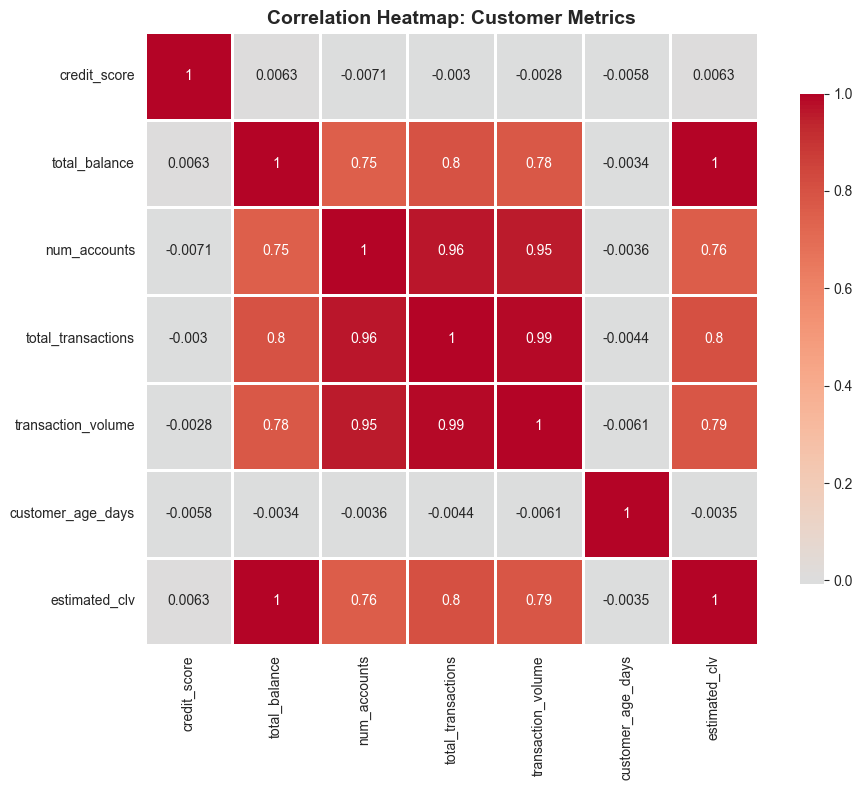

In [ ]:
# Visualize correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_data, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Heatmap: Customer Metrics', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 9. Summary Statistics and Business Insights

In [ ]:
# Comprehensive statistical summary
print("\n=== CUSTOMER METRICS SUMMARY STATISTICS ===")
print(df_clv[['credit_score', 'total_balance', 'num_accounts',
              'total_transactions', 'transaction_volume']].describe())


=== CUSTOMER METRICS SUMMARY STATISTICS ===
       credit_score  total_balance  num_accounts  total_transactions  \
count      10000.00        7727.00      10000.00            10000.00   
mean         575.40     2574452.48          1.49               19.96   
std          159.73     1853616.26          1.22               16.99   
min          300.00         952.28          0.00                0.00   
25%          436.00     1177163.76          1.00                8.00   
50%          576.00     2208254.88          1.00               17.00   
75%          713.00     3577388.37          2.00               30.00   
max          850.00    14693903.19          8.00              119.00   

       transaction_volume  
count            10000.00  
mean             99864.02  
std              86037.90  
min                  0.00  
25%              36428.10  
50%              83816.39  
75%             150677.95  
max             565722.87  


In [ ]:
# City-level performance metrics
query_city_performance = """
SELECT
    COALESCE(c.city, 'Unknown') AS city,
    COUNT(DISTINCT c.customer_id) AS total_customers,
    ROUND(AVG(c.credit_score), 0) AS avg_credit_score,
    ROUND(SUM(a.balance_usd), 2) AS total_balance,
    COUNT(DISTINCT t.transaction_id) AS total_transactions,
    ROUND(SUM(t.amount_usd), 2) AS total_transaction_volume
FROM customers c
LEFT JOIN accounts a ON c.customer_id = a.customer_id
LEFT JOIN transactions t ON a.account_id = t.account_id
GROUP BY c.city
ORDER BY total_balance DESC
LIMIT 15;
"""

df_city_perf = pd.read_sql(query_city_performance, engine)
print("\n=== TOP 15 CITIES BY PERFORMANCE ===")
print(df_city_perf.to_string(index=False))


=== TOP 15 CITIES BY PERFORMANCE ===
          city  total_customers  avg_credit_score  total_balance  total_transactions  total_transaction_volume
 South Michael               56            579.00   127628621.95                1330                6669217.16
  New Jennifer               39            592.00    95689958.17                 894                4492357.34
  Port Michael               39            619.00    94155683.96                1019                5143918.42
     New David               37            546.00    93999847.72                 830                4107221.02
  East Michael               42            587.00    86236110.10                 787                3922814.20
North Jennifer               29            641.00    85893524.04                 700                3512461.78
  Michaelmouth               33            596.00    82368321.47                 755                3680717.53
    South John               29            639.00    78836010.61          

In [ ]:
# Visualize city performance
fig = px.scatter(df_city_perf,
                 x='total_customers',
                 y='total_balance',
                 size='total_transaction_volume',
                 color='avg_credit_score',
                 hover_data=['city'],
                 title='City Performance: Customers vs Balance',
                 labels={'total_customers': 'Total Customers',
                        'total_balance': 'Total Balance (USD)'},
                 color_continuous_scale='Plasma')

fig.update_layout(height=600)
fig.show()

## 10. Key Business Insights and Recommendations

### Customer Segmentation Findings

**Credit Score Distribution:**
- The customer base shows a healthy distribution across credit segments
- High-quality customers (750+ credit score) represent a significant opportunity for premium product offerings
- Lower credit segments may benefit from credit improvement programs and financial education

**Customer Lifetime Value:**
- Top-tier customers demonstrate significantly higher balances and transaction volumes
- Strong positive correlation between credit score and customer value metrics
- Customer age (tenure) shows moderate positive correlation with total balance

### Transaction Insights

**Volume and Trends:**
- Monthly transaction patterns reveal consistent growth opportunities
- Transaction frequency varies significantly across account types
- Weekend vs weekday patterns can inform promotional timing

**Merchant Performance:**
- Top merchants drive substantial transaction volume
- Opportunity for strategic merchant partnerships
- Average transaction values vary significantly by merchant category

### Risk Management

**Portfolio Risk:**
- Loan-to-balance ratios identify potential overextension
- High-value transactions require enhanced monitoring
- Credit score inversely correlates with interest rates (as expected)

**Fraud Detection:**
- Anomalous transaction patterns identified through velocity checks
- Geographic clustering of high-risk accounts warrants investigation
- Dormant accounts with sudden activity spikes require review

### Strategic Recommendations

1. **Customer Retention:** Focus retention efforts on Top 500 CLV customers who represent disproportionate value

2. **Cross-Sell Opportunities:**
   - Target high-balance customers without loans for lending products
   - Promote account diversification to single-account customers

3. **Risk Mitigation:**
   - Implement enhanced monitoring for high loan-to-balance ratio customers
   - Review pricing strategies for lower credit score segments

4. **Geographic Expansion:**
   - Top-performing cities show strong growth potential
   - Consider market expansion in underrepresented high-performing regions

5. **Product Development:**
   - Design products for medium-transaction-frequency customers to increase engagement
   - Create loyalty programs targeting consistent high-volume transactors

### Data Quality Observations

- Overall data quality is strong with minimal missing values
- No significant orphaned records detected
- Date ranges are consistent across tables
- Recommend ongoing data quality monitoring and validation

---

**Next Steps:**
1. Implement predictive models for customer churn and lifetime value
2. Develop real-time fraud detection algorithms
3. Create automated reporting dashboards for executive monitoring
4. Conduct deeper segmentation analysis for marketing campaigns
5. Build propensity models for cross-sell and upsell initiatives

In [ ]:
# Close database connection
engine.dispose()
print("\n=== ANALYSIS COMPLETE ===")
print("Database connection closed successfully")
print(f"Analysis completed at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")


=== ANALYSIS COMPLETE ===
Database connection closed successfully
Analysis completed at: 2026-02-05 12:42:50
